In [1]:
import requests
from openai import OpenAI
from dotenv import load_dotenv
load_dotenv()
client = OpenAI()
import matplotlib.pyplot as plt
import json

GROUP_THEM_URL = "http://127.0.0.1:8080/groupthem"

In [2]:
state = requests.get(GROUP_THEM_URL).json()
state

{'guesses': [],
 'available_words': ['ship',
  'champ',
  'i',
  'craft',
  'best',
  'concerning',
  'about',
  'legend',
  'goat',
  'on',
  'barge',
  'mussel',
  'naval',
  'hare',
  'toward',
  'vessel']}

### WordGuess

In [9]:
todo

{'guesses': [], 'maximum_guesses': 6}

### GroupThem

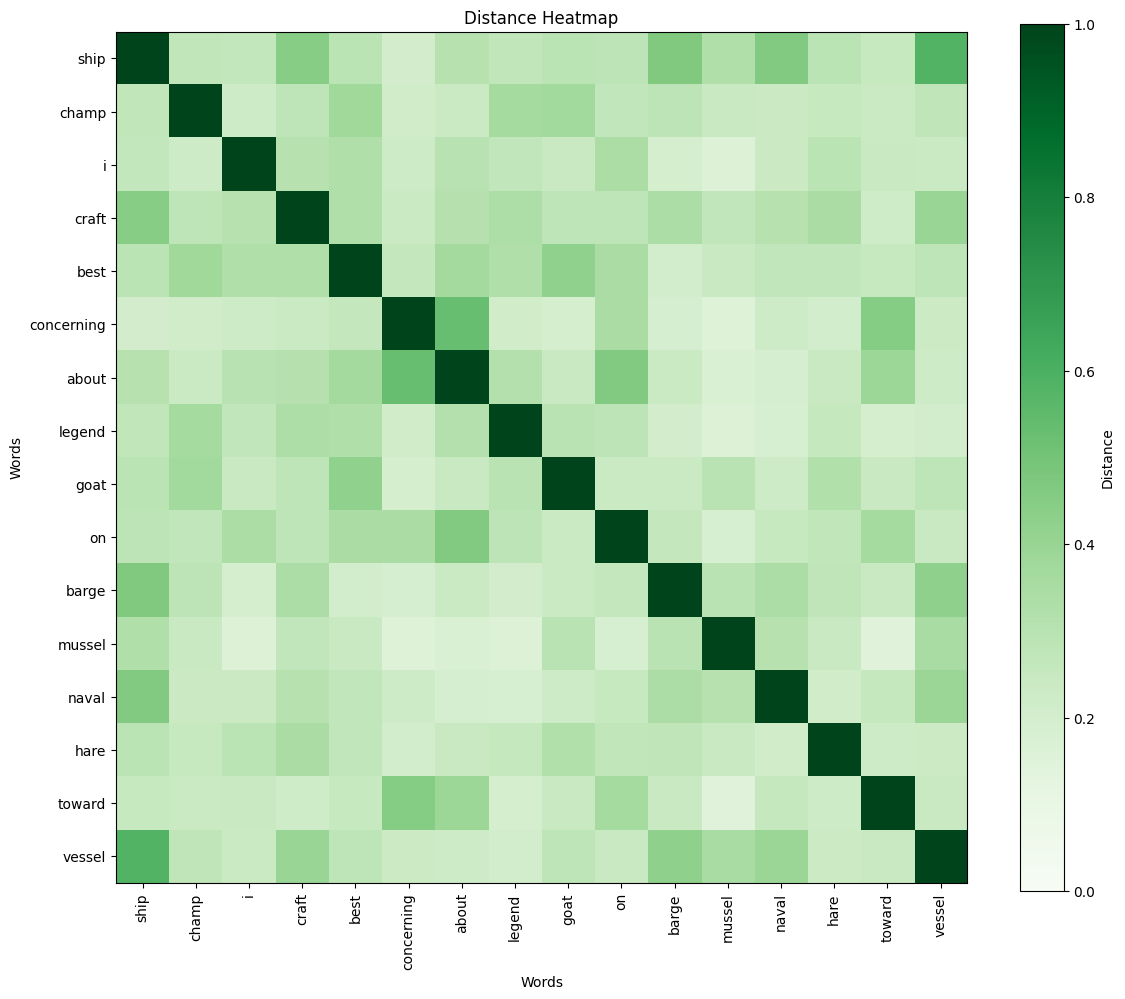

[['ship', 'vessel', 'barge', 'naval'],
 ['concerning', 'about', 'toward', 'on'],
 ['craft', 'hare', 'legend', 'best'],
 ['goat', 'champ', 'mussel', 'i']]

In [3]:
# Embed all words
state = requests.get(GROUP_THEM_URL).json()
words = state["available_words"]

embeddings = [
    x.embedding for x in client.embeddings.create(
        model="text-embedding-3-large",
        input=state["available_words"]
    ).data
]

amount = len(embeddings)
import numpy as np
# Compare all items to eachother
similarity_matrix = np.zeros((amount, amount))

for i in range(amount):
    for j in range(amount):
        if i != j:
            similarity_matrix[i, j] = np.dot(embeddings[i], embeddings[j])
        else:
            similarity_matrix[i, j] = 1

# Plot the similarity matrix as a grid of squares with word labels
plt.figure(figsize=(12, 10))
plt.imshow(similarity_matrix, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)

# Add color bar to interpret the shading
plt.colorbar(label='Distance')

# Set tick labels to words
plt.xticks(ticks=np.arange(amount), labels=words, rotation=90)
plt.yticks(ticks=np.arange(amount), labels=words)

# Add labels for better readability
plt.title('Distance Heatmap')
plt.xlabel('Words')
plt.ylabel('Words')

# Show plot
plt.tight_layout()
plt.show()


### Group the items
# Create a list of dictionaries with words and their similarities
as_sorted_array = [
    {
        "word": words[i],
        "similarities": sorted(
            [{"word": words[j], "similarity": sim} for j, sim in enumerate(similarity_matrix[i]) if i != j],
            key=lambda x: x["similarity"],
            reverse=True
        )
    }
    for i in range(len(words))
]

# Sort based on the highest similarity
as_sorted_array.sort(key=lambda x: x["similarities"][0]["similarity"], reverse=True)

# Create groups of words based on similarity
groups = []
chosen = set()

for item in as_sorted_array:
    if item["word"] in chosen:
        continue
    
    group = [item["word"]]
    chosen.add(item["word"])
    
    for similar in item["similarities"]:
        if len(group) == 4:
            break
        if similar["word"] not in chosen:
            group.append(similar["word"])
            chosen.add(similar["word"])
    
    groups.append(group)

groups

In [6]:
from collections import defaultdict
from enum import Enum

models = ["gpt-4o", "gpt-4o-2024-08-06", "gpt-4o-mini", "gpt-3.5-turbo"]
schema = '{"reasoning": String, "connections": [String; 4]}'

class Status(Enum):
    WIN = 1
    LOSE = 2
    DROPPED = 3
    UKNWN = 4

result = {model: {"guesses": defaultdict(int)} for model in models}

FREQUENCY_INCREASE = 0.5
TEMPERATURE_INCREASE = 0.2
TEMPERATURE_DEFAULT = 1

def process(model: str):
    frequency_penalty = 0
    temperature = TEMPERATURE_DEFAULT
    s = requests.Session()
    state = s.get(GROUP_THEM_URL).json()
    conversation = [
        {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
        {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(state["available_words"]) + "."},
    ]
    
    for i in range(10):
        # Ask model to attempt connection
        response = client.chat.completions.create(
            model=model,
            messages=conversation,
            temperature=max(0, min(temperature, 1.2)),
            frequency_penalty=max(0, min(frequency_penalty, 2)),
        ).choices[0].message.content
        
        start = response.find("{")
        end = response.find("}", start)
        
        conversation.append({"role": "assistant", "content": response})
        
        try:
            json_response = json.loads(response[start:end+1])
        except Exception as e:
            print(response)
            print(e)
            conversation.append({"role": "user", "content": "Invalid JSON object. Please try again following the schema: " + schema})
            continue
        
        print(f"\n>Guess: {json_response['connections']}\nReasoning: {json_response['reasoning']}")
        # Send connections
        payload = {"guess": json_response["connections"]}
        
        try:
            response = s.post(GROUP_THEM_URL, json=payload)
            if response.status_code != 200:
                
                result[model]["guesses"][Status.DROPPED] += 1
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                if "guess already made" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: This guess was already made"})
                    print("Guess already made")
                    continue
                
                if "not a valid word" in response.text.lower():
                    conversation.append({"role": "user", "content": f"WARNING: {response.text}"})
                    print("Invalid word")
                    continue
                
                if "4 words" in response.text.lower():
                    conversation.append({"role": "user", "content": "WARNING: You must provide exactly 4 words"})
                    print("Invalid amount of words")
                    continue
                
                else:
                    print(f"\n### {response.text}")
                    break
            available_words = response.json()["available_words"]
        except Exception as e:
            print(e)
            break
        
        win = json_response["connections"][0] not in available_words
        print(f"Win: {win}\n")
        if len(available_words) == 0:
            print(f"### You won in {i+1} guesses!")
            result[model]
            break
        else:
            
            if win:
                frequency_penalty = 0
                temperature = TEMPERATURE_DEFAULT
                result[model]["guesses"][Status.WIN] += 1
                conversation = [
                    {"role": "system", "content": "You are a helpful assistant. Create a json object with the connection groups & your reasoning. ### Schema\n" + schema },
                    {"role": "user", "content": "Create the mentioned JSON object through trying to find a connection between exactly 4 of these items: " + ", ".join(available_words) + "."},
                ]
            else:
                frequency_penalty += FREQUENCY_INCREASE
                temperature += TEMPERATURE_INCREASE
                result[model]["guesses"][Status.LOSE] += 1
                conversation.append(
                    {"role": "user", "content": "INCORRECT. Important: Try again with DIFFERENT options."}
                )

for model in models:
    print(f"# Model: {model}")
    process(model)
    print("\n---\n")

            

# Model: gpt-4o

>Guess: ['ship', 'barge', 'naval', 'vessel']
Reasoning: The connection between these items is that they are all terms related to types of watercraft or ships.
Win: False


>Guess: ['champ', 'best', 'legend', 'goat']
Reasoning: The connection between these items is that they can be associated with being the best or exceptional in a specific field or context.
Win: True


>Guess: ['ship', 'craft', 'barge', 'vessel']
Reasoning: The connection between the four items 'ship', 'craft', 'barge', and 'vessel' is that they are all types of waterborne vehicles. Each of these terms refers to a vehicle designed to travel on or through water, making them part of a related group in the context of maritime terminology.
Win: True


>Guess: ['concerning', 'about', 'on', 'toward']
Reasoning: The selected items are prepositions or prepositional phrases used to indicate relationships and positions. 'Concerning', 'about', 'on', and 'toward' are all prepositions.
Win: True


>Guess: ['i', 'mu

### Convert to a graph

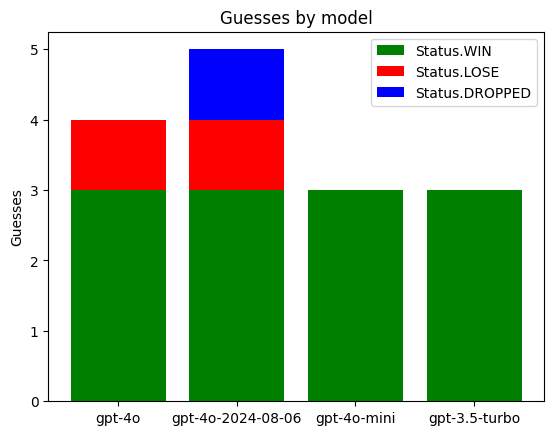

In [7]:


fig, ax = plt.subplots()

for model in models:
    win = result[model]["guesses"][Status.WIN]
    lose = result[model]["guesses"][Status.LOSE]
    dropped = result[model]["guesses"][Status.DROPPED]
    
    ax.bar(model, win, color='g')
    ax.bar(model, lose, bottom=win, color='r')
    ax.bar(model, dropped, bottom=win+lose, color='b')

ax.set_ylabel('Guesses')
ax.set_title('Guesses by model')
ax.legend([Status.WIN, Status.LOSE, Status.DROPPED])
plt.show()